# Clasificación de secuencias con Redes Neuronales Recurrentes 

_____
## Descripción del problema

Nos enrentamos ante un problema clasificación de sentimientos sobre **reseñas de películas en IMDB**. Cada reseña es una secuencia variable de palabras y a cada secuencia se le ha asignado un valor positivo o negativo.

El dataset está compuesto con 50,000 reseñas de películas positivas y negativas, en función de si a los usuarios les ha parecido buenas o malas 

Los datos fueron recogidos por investigadores de la universidad de Stanford con la intención de realizar esta clasificación. La metodología y resultados está disponible en la siguiente [publicación](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf).

## Word Embedding

Word embedding es el nombre de un conjunto de lenguajes de modelado y técnicas de aprendizaje en procesamiento del lenguaje natural (NLP) en donde las palabras o frases del vocabulario son vinculadas a vectores en el espacio real. Conceptualmente implica el encaje matemático de un espacio con una dimensión por palabra a un espacio vectorial continuo con menos dimensiones.

El Word y Phrase embeddings, utilizados de forma subyacente como forma de representación, han demostrado aumentar el rendimiento de tareas en el procesamiento del lenguaje natural, así como en el análisis sintáctico y análisis de sentimientos.

Esta técnica supone una mejora sustancial frente a los esquemas tradicionales de encoding de palabras, que eran usados para representar cada palabra como un vector con respecto a todo un vocabulario. Cuando el vocabulario es vasto, una única palabra por lo general se identificaba con un vector que contenía un gran número de elementos nulos. Sin embargo, en un embedding, las palabras se representan por vectores donde cada vector representa la proyección de una palabra en un espacio vectorial. 

La posición de una palabra en ese espacio vectorial está basada no sólo en las características de la palabra, sino también enlas palabras que la rodean. 
Hay dos ejemplos muy populares de aprendizaje de Word Embedding:

* Word2Vec.
* GloVe.


___
La clasificación de secuencias es un problema de modelado predictivo en el que se tiene una secuencia de entradas sobre el espacio o el tiempo y la tarea es predecir una categoría para la secuencia.

Lo que hace que abarcar este problema no sea inmediato es que las secuencias pueden variar en longitud, estar compuestas de un vocabulario muy grande de símbolos de entrada y pueden requerir que el modelo aprenda el contexto a largo plazo o las relaciones entre símbolos en la secuencia de entrada.

___
## 1. Carga del dataset

Comencemos importando las clases y funciones requeridas para este modelo e inicializando el generador de números aleatorios a un valor constante para asegurar que podamos reproducir fácilmente los resultados.

In [5]:
%matplotlib inline
import time
import numpy as np

from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, BatchNormalization
from keras.datasets import imdb
from keras.callbacks import ModelCheckpoint

import os
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
np.random.seed(2018)

Nos vamos a quedar con este límite de palabras que definimos a continuación.

In [7]:
max_len = 500
max_features = 5000

Definimos un *base_path*.

In [8]:
base_path = os.getcwd()

Podemos acceder al dataset de las reseñar en el siguiente [enlace](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz):

Definimos el conjunto de datos de entrenamiento y testeo descargados. Como vemos, están separados en distintos directorios dependiendo de la naturaleza positiva o negativa de la reseña.

In [9]:
X_train = []
y_train = []

path = os.path.join(base_path, 'data/aclImdb/train/pos/')
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_train.extend([1 for _ in range(12500)])

path = os.path.join(base_path, 'data/aclImdb/train/neg/')
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_train.extend([0 for _ in range(12500)])


In [10]:
X_test = []
y_test = []

path = os.path.join(base_path, 'data/aclImdb/test/pos/')
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([1 for _ in range(12500)])

path = os.path.join(base_path, 'data/aclImdb/test/neg/')
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([0 for _ in range(12500)])

In [11]:
print('Ejemplo de reseña:')
print(X_train[0])
print('------------------------------------------------------')
print('Esta reseña está etiquetada como:')
print(y_train[0])

Ejemplo de reseña:
This movie just pulls you so deeply into the two main characters. I popped it into my laptop without even reading the cover (let alone reviews) and was intrigued for two solid hours. Two lost ships from two different worlds collide. The sexual tension that brews between a secretary and a criminal is almost palpable even without hardly any physical contact. Toward the end I couldn't decide which I wanted more: Our hero and heroine to pull off their caper or simply consummate their passion. RML could've done without a curious subplot and a traditional 100 minutes would have been plenty. I'm nitpicking though. After a series of Netflix, Blockbuster and local library duds this movie restored my faith in great film making.
------------------------------------------------------
Esta reseña está etiquetada como:
1


___
## 2. Procesado del dataset

Hacemos un [Tokenizing](https://keras.io/preprocessing/text/) de las palabras del train y test dataset. 

Anteriormente hemos definido un límite de max_features de 5,000. Esto quiere decir que nos quedamos con las 5,000 palabras más comunes y el resto las dejamos a 0.

Para poder realizar esta tarea hacemos uso de las funciones `Tokenizer()` y `fit_on_texts()`.

In [12]:
imdbTokenizer = Tokenizer(num_words = max_features)

imdbTokenizer.fit_on_texts(X_train)
imdbTokenizer.fit_on_texts(X_test)

Podemos analizar cuántas veces aparece cada palabra en nuestro dataset de la siguiente forma: 

In [13]:
imdbTokenizer.word_counts

OrderedDict([('this', 150941),
             ('movie', 87050),
             ('just', 35154),
             ('pulls', 373),
             ('you', 60308),
             ('so', 40845),
             ('deeply', 599),
             ('into', 17846),
             ('the', 666757),
             ('two', 13520),
             ('main', 4608),
             ('characters', 14243),
             ('i', 154887),
             ('popped', 87),
             ('it', 156801),
             ('my', 24885),
             ('laptop', 29),
             ('without', 6436),
             ('even', 24864),
             ('reading', 1332),
             ('cover', 1178),
             ('let', 3377),
             ('alone', 1962),
             ('reviews', 1441),
             ('and', 324337),
             ('was', 95585),
             ('intrigued', 215),
             ('for', 87450),
             ('solid', 950),
             ('hours', 1946),
             ('lost', 2920),
             ('ships', 163),
             ('from', 40481),
             

Las 20 palabras más usadas en el dataset son (haciendo uso de `imdbTokenizer.word_index.items()`):

In [14]:
for word, value in imdbTokenizer.word_index.items():
    if value < 20:
        print(value, word)

18 but
13 was
3 a
4 of
12 that
8 in
14 as
11 this
9 it
7 br
1 the
5 to
2 and
10 i
6 is
15 for
17 movie
19 film
16 with


Creamos un diccionario de palabras que equipare la variedad de palabras en las reseñas con la tokenización del vocabulario.

In [15]:
intToWord = {}
for word, value in imdbTokenizer.word_index.items():
    intToWord[value] = word

Añadimos un símbolo para el primer valor de nuestro diccionario equiparable a un elemento vacío.

In [16]:
intToWord[0] = "NA"

Podemos echarle un breve vistazo al diccionario.

In [17]:
intToWord

{0: 'NA',
 1: 'the',
 2: 'and',
 3: 'a',
 4: 'of',
 5: 'to',
 6: 'is',
 7: 'br',
 8: 'in',
 9: 'it',
 10: 'i',
 11: 'this',
 12: 'that',
 13: 'was',
 14: 'as',
 15: 'for',
 16: 'with',
 17: 'movie',
 18: 'but',
 19: 'film',
 20: 'on',
 21: 'not',
 22: 'you',
 23: 'are',
 24: 'his',
 25: 'have',
 26: 'be',
 27: 'one',
 28: 'he',
 29: 'all',
 30: 'at',
 31: 'by',
 32: 'an',
 33: 'they',
 34: 'so',
 35: 'who',
 36: 'from',
 37: 'like',
 38: 'or',
 39: 'just',
 40: 'her',
 41: 'out',
 42: 'about',
 43: 'if',
 44: "it's",
 45: 'has',
 46: 'there',
 47: 'some',
 48: 'what',
 49: 'good',
 50: 'when',
 51: 'more',
 52: 'very',
 53: 'up',
 54: 'no',
 55: 'time',
 56: 'my',
 57: 'even',
 58: 'would',
 59: 'she',
 60: 'which',
 61: 'only',
 62: 'really',
 63: 'see',
 64: 'story',
 65: 'their',
 66: 'had',
 67: 'can',
 68: 'me',
 69: 'well',
 70: 'were',
 71: 'than',
 72: 'much',
 73: 'we',
 74: 'bad',
 75: 'been',
 76: 'get',
 77: 'do',
 78: 'great',
 79: 'other',
 80: 'will',
 81: 'also',
 82: '

Con nuestro diccionario construido, podemos tranformar las reseñas a secuencias de enteros.

In [18]:
print(X_train[0])
    
X_train = imdbTokenizer.texts_to_sequences(X_train)
X_test = imdbTokenizer.texts_to_sequences(X_test)

print(X_train[0])

This movie just pulls you so deeply into the two main characters. I popped it into my laptop without even reading the cover (let alone reviews) and was intrigued for two solid hours. Two lost ships from two different worlds collide. The sexual tension that brews between a secretary and a criminal is almost palpable even without hardly any physical contact. Toward the end I couldn't decide which I wanted more: Our hero and heroine to pull off their caper or simply consummate their passion. RML could've done without a curious subplot and a traditional 100 minutes would have been plenty. I'm nitpicking though. After a series of Netflix, Blockbuster and local library duds this movie restored my faith in great film making.
[11, 17, 39, 2595, 22, 34, 1751, 82, 1, 105, 280, 102, 10, 9, 82, 56, 208, 57, 898, 1, 998, 379, 624, 838, 2, 13, 3994, 15, 105, 1192, 631, 105, 432, 4940, 36, 105, 279, 3639, 1, 890, 1089, 12, 201, 3, 3804, 2, 3, 1785, 6, 216, 57, 208, 1031, 99, 1713, 2917, 1987, 1, 127,

A continuación, debemos **truncar o rellenar** las secuencias de entrada para que tengan todas la misma longitud para tanto para el ajuste como para el testeo. 

Para ello hacemos uso de la función de Keras `sequence.pad_sequences()`.

In [21]:
print(len(X_train), 'reseñas de entrenamiento')
print(len(X_test), 'reseñas de testeo')

print("Hacemos un padding de las secuencias, obteniendo las siguientes dimensiones:")
X_train = sequence.pad_sequences(X_train, maxlen = max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

25000 reseñas de entrenamiento
25000 reseñas de testeo
Hacemos un padding de las secuencias, obteniendo las siguientes dimensiones:
X_train shape: (25000, 500)
X_test shape: (25000, 500)


Las etiquetas de nuestro dataset quedan de la siguiente manera:

In [22]:
y_train = np.array(y_train)
y_test = np.array(y_test)

Podemos mostrar a continuación cómo que codifica en enteros una secuencia de palabras pertenecientes a una reseña:

In [23]:
print("x:", X_train[0]) 
print("y:", y_train[0]) 

x: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    

In [26]:
# Comprobamos que las dimensionalidades son las esperadas
print("Distribución de las labels para el training set:", np.unique(y_train, return_counts=True))
print("max x word:", np.max(X_train), "; min x word", np.min(X_train))
print("Distribución de las labels para el test set:", np.unique(y_test, return_counts=True))
print("max x word test:", np.max(X_test), "; min x word", np.min(X_test))

Distribución de las labels para el training set: (array([0, 1]), array([12500, 12500]))
max x word: 4999 ; min x word 0
Distribución de las labels para el test set: (array([0, 1]), array([12500, 12500]))
max x word test: 4999 ; min x word 0


In [27]:
print("Palabras más usadas: ")
print(np.unique(X_train, return_counts=True)[0][1:-1])
print(np.unique(X_train, return_counts=True)[1][1:-1])
# as expected zero is the highly used word for words not in index

Palabras más usadas: 
[   1    2    3 ..., 4996 4997 4998]
[319465 156520 154919 ...,     70     90     84]


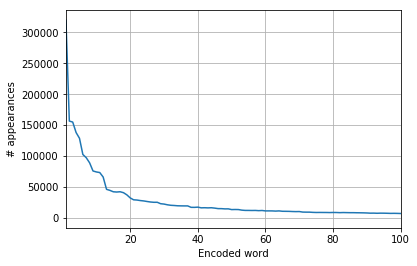

In [28]:
plt.plot(np.unique(X_train, return_counts=True)[0][1:-1], np.unique(X_train, return_counts=True)[1][1:-1])
plt.xlim(1, 100)
plt.xlabel('Encoded word')
plt.ylabel('# appearances')
plt.grid()

___
## 3. Definición, compilación, ajuste y evaluación del modelo con Keras.

Definimos la red neuronal recurrente de manera secuencial con Keras. 

El modelo secuencial de Keras `model = Sequential()` nos permite hacer un stacking de capas muy rápido y sencillo, sin preocuparnos por las dimensionalidades de los pesos y bias tal y como ocurría anteriormente.

Las capas se añaden a través del método `.add()`.

Los modelos necesitan conocer la dimensionalidad del input que deben esperar. Por esta razón, en el modelo secuencial se debe especificar el tamaño del dato con el que se va a alimentar la red en la primera capa (y sólo en la primera capa). El resto de capas hacen inferencia automática de los tamaños.
 

Definimos los hiperparámetros del modelo:
* **épocas** de entrenamiento
* **número** de neuronas de **Embedding**
* **número** de neuronas **LSTM**
* tamaño del **batch**

In [29]:
epochs = 6
embedding_neurons = 128
lstm_neurons = 64
batch_size = 32

____
### Modelo con Embedding + LSTM

Definimos una **Red Neuronal Recurrente LSTM**:

Hacemos un Input a la red neuronal con `Input`. Funciona como PlaceHolder de input.

In [30]:
sequence = Input(shape=(max_len,), dtype='int32')

### Keras Embedding Layer

Keras ofrece la posibilidad de hacer uso de una capa de [Embedding](https://keras.io/layers/embeddings/#embedding) que puede ser usada en redes neuronales dedicadas al procesado de lenguaje natural.

Esta capa requiere que los datos estén procesados como enteros, de tal manera que cada palabra quede representada como un único entero. Para preparar los datos de texto, se puede hacer uso del recurso [Tokenizer API](https://keras.io/preprocessing/text/#tokenizer), que también viene incluído en Keras.

La capa de Embedding se suele inicializar con pesos aleatorios y su misión será la de aprender el `encaje` de todas las palabras del training dataset.

Este tipo de capas se pueden usar de múltiples maneras, como por ejemplo:

- Puede usarse en solitario sólo para aprender el Word Embedding de un diccionario, de tal forma que se pueda almacenar y restablecer en cualquier otro modelo.
- Se puede incorporar como parte de un modelo de Deep Learning como un componente más.
- Se puede también usar para cargar un modelo ya entrenado de Word Embedding a un algoritmo de aprendizaje profundo propio.

La Embedding Layer se debe usar especificando tres argumentos:

* **input_dim**: se refiere al tamaño del vocabulario que estamos manejando.
* **output_dim**: este es el tamaño del espacio vectorial en el que se encajarán las palabras. Este parámetro define la dimensión del vector de salida de la capa para cada palabra. Se suelen elegir valores elevados que dependerán del dataset que se maneje y del problema que estemos afrontando.
* **input_length**: se refiere a la longitud de la secuencia de input a la capa de Embedding.

In [31]:
embedded = Embedding(input_dim = max_features, output_dim = embedding_neurons, input_length = max_len)(sequence)

# Normalizamos los Embeddings haciendo uso de BatchNormalization
bnorm = BatchNormalization()(embedded)

Definimos la capa LSTM.

In [32]:
lstm = LSTM(units=lstm_neurons)(bnorm)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Definimos una capa de output con una única neurona con una función de activación `sigmoid`.

In [33]:
output = Dense(units = 1, activation = 'sigmoid')(lstm)

Podemos definir el modelo con la arquitectura elegida y mostrar un resumen del mismo:

In [34]:
model = Model(input=sequence, output=output)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          640000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 128)          512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 689,985
Trainable params: 689,729
Non-trainable params: 256
_________________________________________________________________
None


/home/eblancoh/anaconda3/envs/universe/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


Compilamos y entrenamos el modelo:

In [35]:
filepath="checkpoints/weights.best.keras.lstm.1.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]

In [108]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print('Comenzando entrenamiento...')
start_time = time.time()

history = model.fit(x=X_train, y=y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=1,
                    callbacks = callbacks_list)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("El tiempo medio de entrenamiento por epoch es:", average_time_per_epoch)

Comenzando entrenamiento...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 1550s - loss: 0.3509 - acc: 0.8476 - val_loss: 0.2803 - val_acc: 0.8849
Epoch 2/6
25000/25000 [==============================] - 1527s - loss: 0.1868 - acc: 0.9296 - val_loss: 0.2999 - val_acc: 0.8782
Epoch 3/6
25000/25000 [==============================] - 1469s - loss: 0.1035 - acc: 0.9615 - val_loss: 0.3566 - val_acc: 0.8705
Epoch 4/6
25000/25000 [==============================] - 1405s - loss: 0.0553 - acc: 0.9808 - val_loss: 0.4268 - val_acc: 0.8659
Epoch 5/6
25000/25000 [==============================] - 1397s - loss: 0.0354 - acc: 0.9880 - val_loss: 0.4827 - val_acc: 0.8690
Epoch 6/6
25000/25000 [==============================] - 1412s - loss: 0.0241 - acc: 0.9927 - val_loss: 0.5593 - val_acc: 0.8711
El tiempo medio de entrenamiento por epoch es: 1460.9496663411458


____
### Accediendo al histórico del entrenamiento con Keras

In [115]:
print(history.history.keys())

dict_keys(['acc', 'loss', 'val_loss', 'val_acc'])


Accedemos a la evolución del histórico del entrenamiento para su visualización.

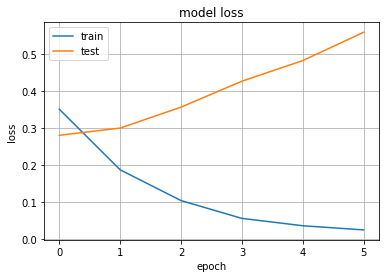

In [116]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

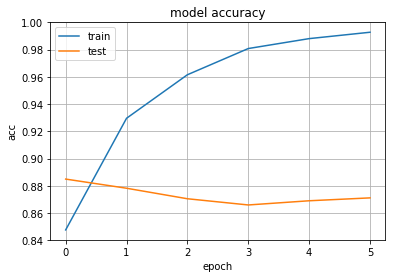

In [119]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

___
### Modelo con Embedding + Bidirectional RNN

Una [Bi-directional RNN](https://es.coursera.org/lecture/nlp-sequence-models/bidirectional-rnn-fyXnn) es una red en la que el gradiente se propaga tanto hacia adelante como hacia atrás en la secuecencia. Resulta tremendamente útil porque tenemos en cuenta no sólo lo que viene detrás de nuestro input, sino también lo que viene inmediatamente delante del mismo, por lo que el aprendizaje mejora con respecto a LSTM.

Lo siguiente está basado en este [tutorial de Keras](https://github.com/fchollet/keras/blob/master/examples/imdb_bidirectional_lstm.py).

In [36]:
# Definimos una secuencia de input a nuestro modelothis is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')

# Volvemos a meter por medio una capa de Embedding
embedded = Embedding(input_dim = max_features, output_dim = embedding_neurons, input_length = max_len)(sequence)

# Normalizamos los Embeddings haciendo uso de BatchNormalization
bnorm = BatchNormalization()(embedded)

# Aplicamos una capa LSTM forward
forwards = LSTM(units=lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# Aplicamos una capa LSTM backwards
backwards = LSTM(units=lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# Concatenamos haciendo uso de la función merge() el resultado de forwards y backwards
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)

# Aplicamos Dropout para la regularización de la red neuronal
after_dp = Dropout(rate=0.5)(merged)

# Definimos una capa de output con activación `sigmoid` 
output = Dense(units=1, activation='sigmoid')(after_dp)

/home/eblancoh/anaconda3/envs/universe/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(dropout=0.4, recurrent_dropout=0.4, units=64)`
  # This is added back by InteractiveShellApp.init_path()
/home/eblancoh/anaconda3/envs/universe/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(go_backwards=True, recurrent_dropout=0.4, dropout=0.4, units=64)`
  del sys.path[0]
/home/eblancoh/anaconda3/envs/universe/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  app.launch_new_instance()
/home/eblancoh/anaconda3/envs/universe/lib/python3.5/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merg

Definimos el modelo con la arquitectura indicada.

In [37]:
model_brnn = Model(input=sequence, output=output)

/home/eblancoh/anaconda3/envs/universe/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


Mostramos un resumen del `summary` del modelo.

In [38]:
print(model_brnn.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 500)           0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 500, 128)      640000      input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (None, 500, 128)      512         embedding_2[0][0]                
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 64)            49408       batch_normalization_2[0][0]      
___________________________________________________________________________________________

Compilamos y entrenamos el modelo:

In [39]:
filepath="checkpoints/weights.best.keras.brnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]

In [121]:
model_brnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print('Comenzando el entrenamiento...')
start_time = time.time()

history_brnn = model_brnn.fit(x=X_train, y=y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=1,
                    callbacks = callbacks_list)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("El tiempo medio de entrenamiento por epoch es:", average_time_per_epoch)

Comenzando el entrenamiento...
Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 1802s - loss: 0.4954 - acc: 0.7476 - val_loss: 0.3215 - val_acc: 0.8698
Epoch 2/6
25000/25000 [==============================] - 1941s - loss: 0.2686 - acc: 0.8940 - val_loss: 0.3120 - val_acc: 0.8790
Epoch 3/6
25000/25000 [==============================] - 1893s - loss: 0.1951 - acc: 0.9264 - val_loss: 0.3508 - val_acc: 0.8760
Epoch 4/6
25000/25000 [==============================] - 1935s - loss: 0.1523 - acc: 0.9443 - val_loss: 0.3737 - val_acc: 0.8774
Epoch 5/6
25000/25000 [==============================] - 1754s - loss: 0.1242 - acc: 0.9558 - val_loss: 0.4140 - val_acc: 0.8710
Epoch 6/6
25000/25000 [==============================] - 1627s - loss: 0.1025 - acc: 0.9637 - val_loss: 0.4747 - val_acc: 0.8682
El tiempo medio de entrenamiento por epoch es: 1826.3123924334843


___
### Comparación de clasificación con Regresión Logística 

Los resultados obtenidos anteriormente se pueden comparar con una regresión logística sencilla. El siguiente apartado se basa en el siguiente [Jupyter Notebook](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch08/ch08.ipynb).

Los vectores  **tf-idf** se utilizan a menudo como un factor de ponderación en la recuperación de información y la minería de texto. El valor **tf-idf** aumenta proporcionalmente al número de veces que una palabra aparece en el documento, pero es compensada por la frecuencia de la palabra en la colección de documentos, lo que permite manejar el hecho de que algunas palabras son generalmente más comunes que otras.

In [123]:
tfidfTokenizer = Tokenizer(num_words=max_features)
tfidfTokenizer.fit_on_sequences(X_train.tolist())

X_train_tfidf = np.asarray(tfidfTokenizer.sequences_to_matrix(X_train.tolist(), mode="tfidf"))
X_test_tfidf = np.asarray(tfidfTokenizer.sequences_to_matrix(X_test.tolist(), mode="tfidf"))

/home/eblancoh/anaconda3/envs/universe/lib/python3.5/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Comprobamos la matriz **td-idf** generada.

In [124]:
print(X_train_tfidf)
print(X_train_tfidf.shape, X_test_tfidf.shape)

[[ 5.0780096   1.66394589  1.85347782 ...,  0.          0.          0.        ]
 [ 5.06068274  2.05416196  1.49063954 ...,  0.          0.          0.        ]
 [ 4.90973423  2.14727243  1.69497946 ...,  0.          0.          0.        ]
 ..., 
 [ 5.00188026  2.30286883  1.49063954 ...,  0.          0.          0.        ]
 [ 5.07419454  2.05416196  1.20263859 ...,  0.          0.          0.        ]
 [ 5.06262837  2.05416196  0.71029773 ...,  0.          0.          0.        ]]
(25000, 10000) (25000, 10000)


Con `sklearn.linear_model` importamos `LogisticRegression`.

In [125]:
from sklearn.linear_model import LogisticRegression

model_tfidf_reg = LogisticRegression(random_state=0, C=0.001, penalty='l2', verbose=1)
model_tfidf_reg.fit(X_train_tfidf, y_train)

[LibLinear]

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)

Calculamos la accuracy del modelo con `accuracy_score`

In [126]:
from sklearn.metrics import accuracy_score

print("train acc:", accuracy_score(y_test, model_tfidf_reg.predict(X_train_tfidf)))
print("test acc:", accuracy_score(y_test, model_tfidf_reg.predict(X_test_tfidf)))

train acc: 0.9424
test acc: 0.88992


La accuracy de este método es sorprendentemente buena, también comparando el tiempo de entrenamiento.

Los métodos en los que no se incluyen arquitecturas profundas no funcionan mal tampoco, siempre y cuando el volumen de datos y la complejidad de la regresión logística no sea muy elevada. En este ejemplo teneos que clasificar entre dos clases con 25,000 elementos de entrenamiento. Si contáramos con millones de reseñas y un mayor número de labels, la red neuronal batiría sin dudarlo a la regresión logística.

Resulta curioso poder visualizar el comportamiento de nuestro modelo a nivel de pesos de la capa de Embedding.

Podemos acceder a los pesos de la siguiente manera:

In [45]:
print(model_brnn.layers[1].get_config())

embmatrix = model_brnn.layers[1].get_weights()[0]

print(embmatrix.shape)

{'output_dim': 128, 'trainable': True, 'embeddings_regularizer': None, 'batch_input_shape': (None, 500), 'activity_regularizer': None, 'name': 'embedding_2', 'input_dim': 5000, 'input_length': 500, 'embeddings_constraint': None, 'mask_zero': False, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'seed': None, 'minval': -0.05, 'maxval': 0.05}}, 'dtype': 'int32'}
(5000, 128)


**T-distributed Stochastic Neighbor Embedding (t-SNE)** es un algoritmo de Machine Learning para la visualización desarrollado por Laurens van der Maaten y Geoffrey Hinton. Es una técnica de reducción de dimensionalidad no lineal adecuada para incorporar datos de alta dimensión para visualización en un espacio de baja dimensión de dos o tres dimensiones. Esta técnica normalmente suele usarse como recurso para visualizar las caracterśiticas aprendidas por las redes neuronales profundas.

In [46]:
from sklearn.manifold import TSNE

# Nos quedamos con las 5000 palabras más habituales
topnwords = 5000

# Aplicamos la transformación al subset de los pesos de la matriz de la capa de Embedding
toptsne = TSNE(n_components=2, random_state=0)
tsneXY = toptsne.fit_transform(embmatrix[:topnwords, :]) 
tsneXY.shape

(5000, 2)

Una vez obtenida la transformación en 2 componentes de los pesos de la capa de Embedding, podemos plotear 

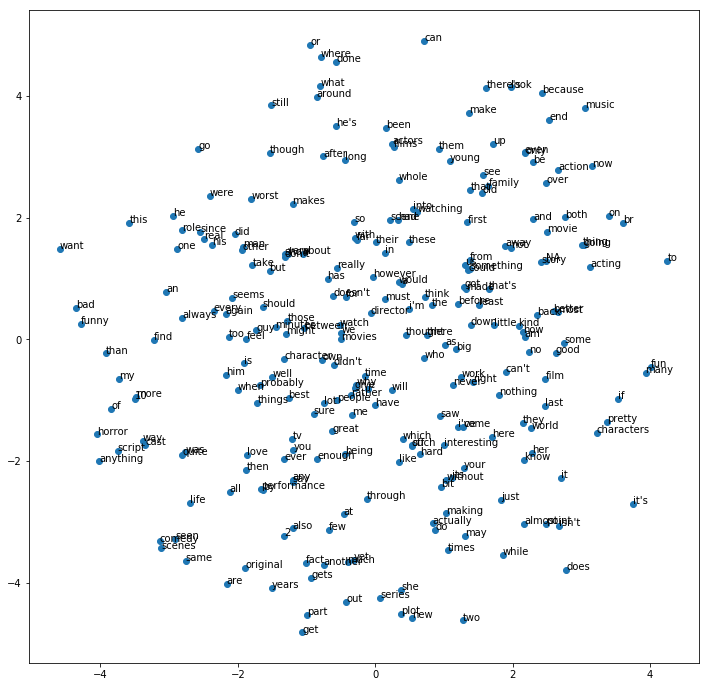

In [47]:
# Queremos plotear sólo las 250 primeras palabras más usadas.
displaytopnwords = 250

fig, ax = plt.subplots()
ax.scatter(tsneXY[:displaytopnwords, 0], tsneXY[:displaytopnwords, 1])

for i in range(displaytopnwords):
    ax.annotate(intToWord[i], (tsneXY[i, 0], tsneXY[i, 1]))

fig.set_size_inches(12, 12)
plt.show()

Resulta complicado visualizar grupos de palabras que decanten la naturaleza de una reseña como positiva o negativa. A pesar de ello, parece que nuestro modelo es capaz de aprender los sentimientos de una reseña.